In [ ]:
cd /content/drive/MyDrive/Segmentation/dataset1

/content/drive/MyDrive/Segmentation/dataset1


In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import os
import PIL
from PIL import Image, ImageOps 
from IPython.display import  display
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
import cv2
import matplotlib.pyplot as plt

In [ ]:
img_size = (360,480)
nClasses = 50

In [ ]:
input_image_paths=[sorted(os.path.join(os.getcwd(),"images_prepped_train/"+path) for path in os.listdir("images_prepped_train"))]
output_image_paths=[sorted(os.path.join(os.getcwd(),"annotations_prepped_train/"+path) for path in os.listdir("annotations_prepped_train"))]

In [ ]:
print(input_image_paths[0][10])
print(output_image_paths[0][10])

/content/drive/MyDrive/Segmentation/dataset1/images_prepped_train/0001TP_006990.png
/content/drive/MyDrive/Segmentation/dataset1/annotations_prepped_train/0001TP_006990.png


In [ ]:
im1 = Image.open(output_image_paths[0][22])

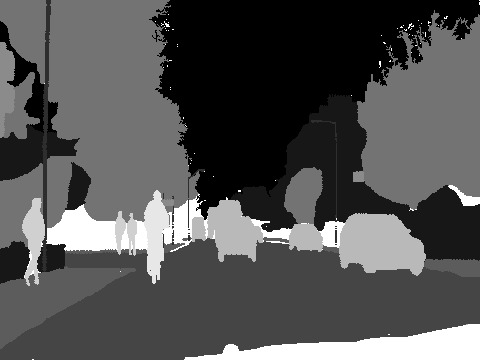

In [ ]:
img = PIL.ImageOps.autocontrast(im1,cutoff=5)
display(img)

In [ ]:
def convert(path,img_size):
    x = np.zeros((len(path),) +img_size + (3,), dtype="float32")
    for j, image in enumerate(path):
        img = load_img(image, target_size=img_size)
        x[j] = img
    return x

In [ ]:
x=convert(input_image_paths[0],img_size)
y=convert(output_image_paths[0],(368,480))

In [ ]:
height=368
width= 480

In [ ]:
z=np.zeros((367,368,480,50),dtype="bool")
for i,img in enumerate(y):
  seg_labels = np.zeros((height, width, nClasses))
  img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  img = img[:, :, 0]
  for c in range(50):
    seg_labels[:, :, c] = (img == c).astype(int)
    z[i]=seg_labels

## To define model

In [ ]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(50, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [ ]:
keras.backend.clear_session()

# Build model
model = get_model(img_size, nClasses)
model.summary()

In [ ]:
keras.backend.clear_session()

## Load pretrained model

In [ ]:
model=keras.models.load_model("final_model")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 360, 480, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 180, 240, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 180, 240, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 180, 240, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
y=0

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(x,z,batch_size=1,epochs=25, callbacks=callbacks)

Epoch 1/25
367/367 [==============================] - 28s 67ms/step - loss: 0.1561
Epoch 2/25
367/367 [==============================] - 25s 67ms/step - loss: 0.1501
Epoch 3/25
367/367 [==============================] - 25s 68ms/step - loss: 0.1468
Epoch 4/25
367/367 [==============================] - 25s 68ms/step - loss: 0.1438
Epoch 5/25
367/367 [==============================] - 25s 68ms/step - loss: 0.1387
Epoch 6/25
367/367 [==============================] - 25s 68ms/step - loss: 0.1368
Epoch 7/25
367/367 [==============================] - 25s 68ms/step - loss: 0.1340
Epoch 8/25
367/367 [==============================] - 25s 69ms/step - loss: 0.1300
Epoch 9/25
367/367 [==============================] - 25s 69ms/step - loss: 0.1285
Epoch 10/25
367/367 [==============================] - 25s 69ms/step - loss: 0.1269
Epoch 11/25
367/367 [==============================] - 25s 69ms/step - loss: 0.1238
Epoch 12/25
367/367 [==============================] - 25s 69ms/step - loss: 0.1218
E

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
import numpy

In [ ]:
x[10].shape

(360, 480, 3)

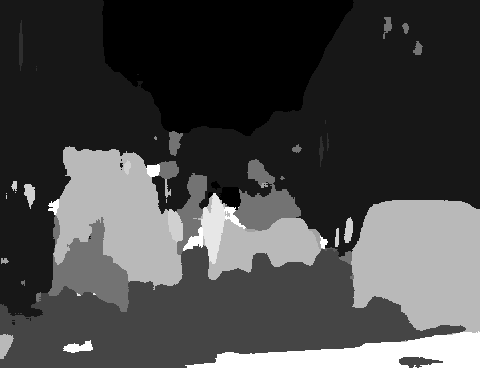

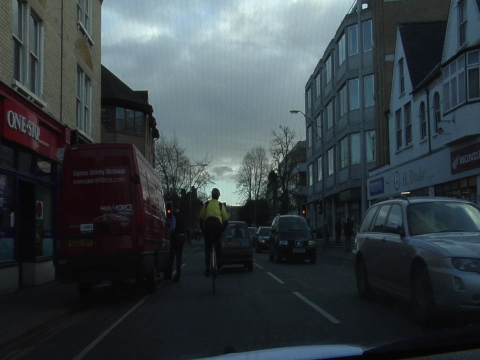

In [ ]:
output=model.predict([x[57].reshape((1,360,480,3))])
mask = np.argmax(output[0], axis=-1)
mask = np.expand_dims(mask, axis=-1)
img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
display(img)
display(keras.preprocessing.image.array_to_img(x[57]))
# display(keras.preprocessing.image.array_to_img(y[11]))

In [ ]:
model.save("final_model2")

INFO:tensorflow:Assets written to: final_model2/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
output=output>0.25

In [ ]:
output

array([[[[False, False, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         ...,
         [False,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [ True,  True, False, ..., False, False, False],
         ...,
         [ True,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]],

        [[False, False, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         [False,  True, False, ..., False, False, False],
         ...,
         [False,  True, False, ..., False, False, False],
         [False,  True, Fa

Resources : https://keras.io/examples/vision/oxford_pets_image_segmentation/
2. https://keras.io/api/models/model_training_apis/
3. https://github.com/divamgupta/image-segmentation-keras/tree/master/keras_segmentation